<a href="https://colab.research.google.com/github/rish4/Minor-Project/blob/main/VGG_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
# https://deeplearningcourses.com/c/advanced-computer-vision
# https://www.udemy.com/advanced-computer-vision
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

In [47]:
# re-size all the images to this
IMAGE_SIZE = [100, 100] # feel free to change depending on dataset

# training config:
epochs = 5
batch_size = 32

In [48]:
# https://www.kaggle.com/moltean/fruits
train_path = '/content/drive/MyDrive/Dogs cats dataset/training_set'
valid_path = '/content/drive/MyDrive/Dogs cats dataset/validation_set'

In [49]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

In [50]:
# useful for getting number of classes
folders = glob(train_path + '/*')

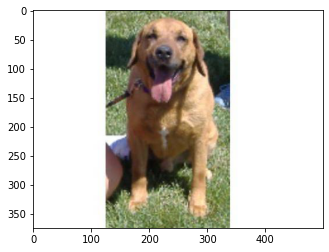

In [51]:
# look at an image for fun
plt.imshow(image.img_to_array(image.load_img(np.random.choice(image_files))).astype('uint8'))
plt.show()

In [52]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [55]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [56]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0   

In [57]:
# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)


In [58]:
# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 1000 images belonging to 2 classes.
{'cats': 0, 'dogs': 1}


min: -83.03003 max: 151.061


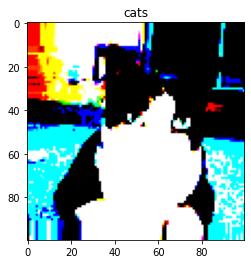

In [59]:
# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [60]:
# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 8000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [61]:
# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/5
250/250 [==============================] - 958s 4s/step - loss: 3.4664 - accuracy: 0.8011 - val_loss: 2.7796 - val_accuracy: 0.8266
Epoch 2/5
250/250 [==============================] - 952s 4s/step - loss: 2.8196 - accuracy: 0.8334 - val_loss: 3.1883 - val_accuracy: 0.8427
Epoch 3/5
250/250 [==============================] - 947s 4s/step - loss: 2.7929 - accuracy: 0.8422 - val_loss: 2.8847 - val_accuracy: 0.8478
Epoch 4/5
250/250 [==============================] - 952s 4s/step - loss: 2.6438 - accuracy: 0.8559 - val_loss: 3.6374 - val_accuracy: 0.8145
Epoch 5/5
250/250 [==============================] - 953s 4s/step - loss: 2.7176 - accuracy: 0.8565 - val_loss: 3.3907 - val_accuracy: 0.8387


In [62]:
model.save('/content/drive/MyDrive/Minor Project/Saved Models/VGG-4.h5')

In [63]:
import tensorflow as tf

In [64]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Minor Project/Saved Models/VGG-4.h5')
loaded_model.layers[0].input_shape #(None, 160, 160, 3)

[(None, 100, 100, 3)]

In [65]:
'''batch_holder = np.zeros((1, IMAGE_SIZE, IMAGE_SIZE, 3))
img_dir='/content/drive/MyDrive/Dogs cats dataset/test_set'
for i,img in enumerate(os.listdir(img_dir)):
  img = image.load_img(os.path.join(img_dir,img), target_size=(IMAGE_SIZE,IMAGE_SIZE))
  batch_holder[i, :] = img'''
  

"batch_holder = np.zeros((1, IMAGE_SIZE, IMAGE_SIZE, 3))\nimg_dir='/content/drive/MyDrive/Dogs cats dataset/test_set'\nfor i,img in enumerate(os.listdir(img_dir)):\n  img = image.load_img(os.path.join(img_dir,img), target_size=(IMAGE_SIZE,IMAGE_SIZE))\n  batch_holder[i, :] = img"

In [66]:
'''result=loaded_model.predict_classes(batch_holder)

fig = plt.figure(figsize=(20, 20))

for i,img in enumerate(batch_holder):
  fig.add_subplot(4,5, i+1)
  plt.title(get_label_name(result[i][0]))
  plt.imshow(img/256.)
  
plt.show()'''

'result=loaded_model.predict_classes(batch_holder)\n\nfig = plt.figure(figsize=(20, 20))\n\nfor i,img in enumerate(batch_holder):\n  fig.add_subplot(4,5, i+1)\n  plt.title(get_label_name(result[i][0]))\n  plt.imshow(img/256.)\n  \nplt.show()'

In [67]:
# import the necessary packages
'''
from tensorflow.keras.models import load_model
import argparse
import pickle
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.imagenet_utils import decode_predictions
import numpy as np
import logging, os
import sys 
from keras.preprocessing import image
import tensorflow as tf
import math
import operator
from pathlib import Path

# disable the warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

image_path = '/content/drive/MyDrive/Dogs cats dataset/test_set'

images = []
    
# load all images into a list
for img in os.listdir(image_path):
        img = os.path.join(image_path, img)
        img = image.load_img(img, target_size=(100,100))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        # normalize the image
        processed_image = np.array(img, dtype="float") / 255.0
        images.append(processed_image)
        
images = np.vstack(images)

# relative paths to the model and labels
model_path = os.path.join("Output", 'VGG_model.h5')
#model_path = '/content/drive/MyDrive/Minor Project/Saved Models/VGG_model.h5'
label_file_path = os.path.join("Output", 'labels')
#label_file_path='/content/drive/MyDrive/Minor Project/Saved Models/labels'
'''



'\nfrom tensorflow.keras.models import load_model\nimport argparse\nimport pickle\nimport cv2\nfrom tensorflow.keras.preprocessing.image import img_to_array\nfrom tensorflow.keras.applications.imagenet_utils import decode_predictions\nimport numpy as np\nimport logging, os\nimport sys \nfrom keras.preprocessing import image\nimport tensorflow as tf\nimport math\nimport operator\nfrom pathlib import Path\n\n# disable the warnings\nlogging.disable(logging.WARNING)\nos.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"\n\nimage_path = \'/content/drive/MyDrive/Dogs cats dataset/test_set\'\n\nimages = []\n    \n# load all images into a list\nfor img in os.listdir(image_path):\n        img = os.path.join(image_path, img)\n        img = image.load_img(img, target_size=(100,100))\n        img = image.img_to_array(img)\n        img = np.expand_dims(img, axis=0)\n        # normalize the image\n        processed_image = np.array(img, dtype="float") / 255.0\n        images.append(processed_image)\n        \nim

In [68]:
# load the model and the label encoder
'''model = load_model(model_path)
lb = pickle.loads(open(label_file_path, "rb").read())

# make a prediction on the image
images_data = []
filenames = []
for filename in os.listdir(image_path):    
    pred_result = model.predict(images)
    images_data.append(pred_result)
    filenames.append(filename)

#sorts attributes according to confidence score (how probable attribute exists)
top_k = []
pred = [] 
for i in range(len(images_data[0])):
            rank = images_data[i].argsort()[-len(images_data[i]):][::-1]
            top_k.append(rank)
            top = top_k[i][:15]
            print(filenames[i])
            for node_id in top:
                human_string = label_file_path[node_id]
                score = images_data[i][0][node_id]
                print('%s (score = %.5f)' % (human_string, score))'''

'model = load_model(model_path)\nlb = pickle.loads(open(label_file_path, "rb").read())\n\n# make a prediction on the image\nimages_data = []\nfilenames = []\nfor filename in os.listdir(image_path):    \n    pred_result = model.predict(images)\n    images_data.append(pred_result)\n    filenames.append(filename)\n\n#sorts attributes according to confidence score (how probable attribute exists)\ntop_k = []\npred = [] \nfor i in range(len(images_data[0])):\n            rank = images_data[i].argsort()[-len(images_data[i]):][::-1]\n            top_k.append(rank)\n            top = top_k[i][:15]\n            print(filenames[i])\n            for node_id in top:\n                human_string = label_file_path[node_id]\n                score = images_data[i][0][node_id]\n                print(\'%s (score = %.5f)\' % (human_string, score))'

In [89]:
'''from PIL import Image
import numpy as np
from skimage import transform
from keras.preprocessing import image
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (100, 100, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image
   
import os
cat_count=0
dog_count=0
directory = r'/content/drive/MyDrive/Dogs cats dataset/test_set'
for entry in os.scandir(directory):
    if (entry.path.endswith(".jpg")
            or entry.path.endswith(".png")) and entry.is_file():
        #print(entry.path)
        image = load(entry.path)
        print(model.predict(image))
        if model.predict(image)[0][0]>0.5:
          cat_count=cat_count+1
          #print("Cat \n")
        else:
          dog_count=dog_count+1
          #print("Dog \n")
print(cat_count)
print("\n")
print(dog_count)
'''

'from PIL import Image\nimport numpy as np\nfrom skimage import transform\nfrom keras.preprocessing import image\ndef load(filename):\n   np_image = Image.open(filename)\n   np_image = np.array(np_image).astype(\'float32\')/255\n   np_image = transform.resize(np_image, (100, 100, 3))\n   np_image = np.expand_dims(np_image, axis=0)\n   return np_image\n   \nimport os\ncat_count=0\ndog_count=0\ndirectory = r\'/content/drive/MyDrive/Dogs cats dataset/test_set\'\nfor entry in os.scandir(directory):\n    if (entry.path.endswith(".jpg")\n            or entry.path.endswith(".png")) and entry.is_file():\n        #print(entry.path)\n        image = load(entry.path)\n        print(model.predict(image))\n        if model.predict(image)[0][0]>0.5:\n          cat_count=cat_count+1\n          #print("Cat \n")\n        else:\n          dog_count=dog_count+1\n          #print("Dog \n")\nprint(cat_count)\nprint("\n")\nprint(dog_count)\n'

In [88]:
import numpy as np
from keras.preprocessing import image
import cv2
import os
import glob
img_dir='/content/drive/MyDrive/Dogs cats dataset/test_set'

cat_count=0
dog_count=0         
#img_dir =  # Enter Directory of all images 

data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
data = []
  
for f1 in files:
    #img = cv2.imread(f1)
    #data.append(img)
    test_image= image.load_img(f1, target_size=(100,100))
    test_image=image.img_to_array(test_image)
    test_image= np.expand_dims(test_image, axis=0)
    result=model.predict(test_image)
    #print(result)
    prediction=[]
    if result[0][0] == 1:
        prediction='cat'
        cat_count=cat_count+1
    else:
        prediction='dog'
        dog_count=dog_count+1
print("No. of total images =", 1000)

print("No. of cat images in the test set = 500 ")

print("No. of cat images predicted =", cat_count)

print("No. of dog images in the test set = 500")

print("No. of dog images predicted =", dog_count)
#print(n)

No. of total images = 1000
No. of cat images in the test set = 500 
No. of cat images predicted = 474
No. of dog images in the test set = 500
No. of dog images predicted = 526


In [70]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  import seaborn as sns
  f = sns.heatmap(cm, annot=True,cmap='Blues',fmt='d')
  
  TN, FP, FN, TP = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
  accuracy = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
  precision = TP / (TP+FP) # % positive out of all predicted positives
  recall =  TP / (TP+FN) # % positive out of all supposed to be positives
  specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
  f1 = 2*precision*recall / (precision + recall)
  stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
  print(stats_summary)

  return cm

Generating confusion matrix 8000
Found 8000 images belonging to 2 classes.
50
100
[Summary Statistics]
Accuracy = 86.33% | Precision = 89.72% | Recall = 82.05% | Specificity = 90.60% | F1 Score = 85.71%
[[3624  376]
 [ 718 3282]]


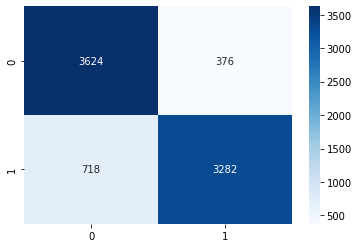

In [71]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)


Generating confusion matrix 1000
Found 1000 images belonging to 2 classes.
[Summary Statistics]
Accuracy = 84.40% | Precision = 86.60% | Recall = 81.40% | Specificity = 87.40% | F1 Score = 83.92%
[[437  63]
 [ 93 407]]


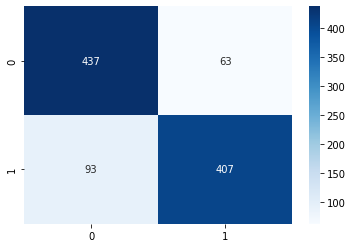

In [72]:
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

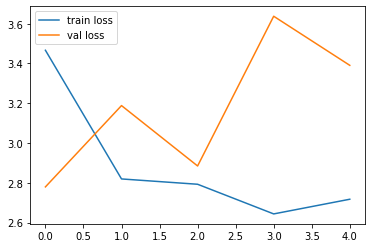

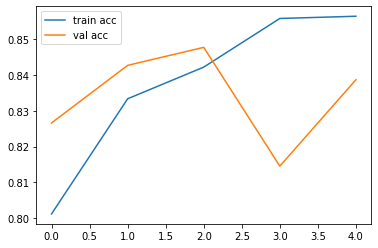

In [73]:
# plot some data

# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()